# Imports

In [37]:
import yfinance
from darts import TimeSeries
from darts.models import TiDEModel
from darts.metrics import mae

import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt

# Utils

In [54]:
def load_data(start_date_str='1990-01-02', end_date_str='2024-03-20', split_date_str='2023-01-01', csv_file=None, apply_filter=False, debug=False):
    """

    """
    df: pd.DataFrame = None
    if not csv_file:
        df:pd.DataFrame = yfinance.download("^GSPC",start=start_date_str, end=end_date_str)
        # Keep only the Close Price and the Volume
        df['Price'] = df['Close']
        df = df.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close'])
        if debug:
            print(f'✅Data loaded from yfinance. Rows: {len(df)}.')
    else:
        # Read the TimeSeries data from csv_file
        df: pd.DataFrame = pd.read_csv(csv_file, sep='\t')
        df.Date = pd.Series([pd.Timestamp(date) for date in df.Date])
        df = df.set_index('Date')
        if debug:
            print(f'✅Data loaded from csv file. Rows: {len(df)}.')

    # Do a forward fill for the missing Business Days
    business_days = pd.date_range(start=start_date_str, end= end_date_str, freq='B')
    df = df.reindex(business_days).ffill()
    if debug:
        print(f'✅Forward fill executed over the prices. Rows: {len(df)}.')

    # Convert the DataFrame into a TimeSeries data type
    price_ts = TimeSeries.from_dataframe(df, time_col=None, value_cols=['Price'], fill_missing_dates=False, freq='B')
    volume_ts = TimeSeries.from_dataframe(df, time_col=None, value_cols=['Volume'], fill_missing_dates=False, freq='B')
    if debug:
        print('✅DataFrame converted into TimeSeries dtype.')
        print(f'\tPrice TS len: {len(price_ts)}')
        print(f'\tVolume TS len: {len(volume_ts)}')
    
    if apply_filter:
        price_ts = apply_butterworth_filter(price_ts,debug=True)

    # Split the data into train...test TimeSeries
    split_date = pd.Timestamp(split_date_str)
    price_train_ts, price_test_ts = price_ts.split_before(split_date)
    volume_train_ts, volume_test_ts = volume_ts.split_before(split_date)

    # TiDE requires float32 dtype
    price_train_ts, price_test_ts = price_train_ts.astype(np.float32), price_test_ts.astype(np.float32)
    volume_train_ts, volume_test_ts = volume_train_ts.astype(np.float32), volume_test_ts.astype(np.float32)

    if debug:
        print('✅TimeSeries splitted into train/test TimeSeries.')
        print(f'\tPrice Train TS len / Price Test TS len: {len(price_train_ts)} / {len(price_test_ts)}')
        print(f'\tVolume Train TS len / Volume Test TS len: {len(volume_train_ts)} / {len(volume_test_ts)}')

    price = {
        'ts' : price_ts,
        'train_ts' : price_train_ts,
        'test_ts' : price_test_ts
    }

    volume = {
        'ts' : volume_ts,
        'train_ts' : volume_train_ts,
        'test_ts' : volume_test_ts
    }
    return df, price, volume
    
def plot_predictions(test_ts: TimeSeries, predictions_ts: TimeSeries, title=""):
    plt.figure(figsize=(12,10))
    test_ts.plot(label='Test', lw=1)
    predictions_ts.plot(label='Predictions', lw=0.5)

    plt.title(title)
    plt.legend()
    plt.show()

def plot_data(data: TimeSeries, title=""):
    plt.figure(figsize=(12,10))
    data.plot()
    plt.title(title)
    plt.show()

def plot_multiple_data(label_data: dict, title=""):
    plt.figure(figsize=(15,10))
    for label, data in label_data.items():
        data.plot(label=label)
    plt.title(title)
    plt.legend()
    plt.show()


def train_tide(train_ts: TimeSeries, params: dict=None, debug=False) -> TiDEModel:
    if not params:
        params = {
            'hidden_size': 128, 
            'input_chunk_length': 90, 
            'output_chunk_length': 318, 
            'n_epochs': 500, 
            'num_decoder_layers': 2, 
            'num_encoder_layers': 2, 
            'temporal_decoder_hidden': 64, 
            'random_state':50,
            'show_warnings':True
        }
    model = TiDEModel(**params)
    if debug:
        print(f'✅TiDE model initialized with params: {params}.')

    model.fit(train_ts)
    if debug:
        print('✅Model fit completed.')
    return model

def get_predictions(model: TiDEModel, length: int, debug=False):
    predictions:TimeSeries = model.predict(length, verbose=True)
    if debug:
        print('✅Predictions extracted.')
    return predictions

def get_mse(test_ts: TimeSeries, predictions_ts: TimeSeries, debug= False):
    actual_values = test_ts.values().flatten()
    predicted_values = predictions_ts.values().flatten()
    
    mse = np.mean((actual_values - predicted_values) ** 2)
    if debug:
        print(f'✅MSE calculated: {mse}')

    return mse

def apply_butterworth_filter(time_series: TimeSeries, order: int = 3, critical_frequency: float = 0.05, debug=False) -> TimeSeries:
    """
    Applies a zero-phase Butterworth filter to a given TimeSeries object using filtfilt.

    Parameters:
    - time_series: The TimeSeries object to filter.
    - order: The order of the Butterworth filter (default is 3).
    - critical_frequency: The critical frequency for the filter, normalized (default is 0.05).
    - debug: If True, print debug information.

    Returns:
    - A new TimeSeries object with the filtered data.
    """
    # Extract values and timestamps from the TimeSeries object
    values = time_series.values().flatten()
    times = time_series.time_index

    # Design the Butterworth filter
    b, a = butter(order, critical_frequency, btype='low', analog=False)

    # Apply the filter to the data using filtfilt for zero-phase filtering
    filtered_values = filtfilt(b, a, values)

    # Create a new TimeSeries object with the filtered data
    filtered_series = TimeSeries.from_times_and_values(times, filtered_values, freq=time_series.freq_str)

    if debug:
        print("✅ Zero-phase Butterworth filter applied.")

    return filtered_series


[*********************100%%**********************]  1 of 1 completed

✅Data loaded from yfinance. Rows: 8619.
✅Forward fill executed over the prices. Rows: 8927.
✅DataFrame converted into TimeSeries dtype.
	Price TS len: 8927
	Volume TS len: 8927
✅TimeSeries splitted into train/test TimeSeries.
	Price Train TS len / Price Test TS len: 8609 / 318
	Volume Train TS len / Volume Test TS len: 8609 / 318
✅ Zero-phase Butterworth filter applied.


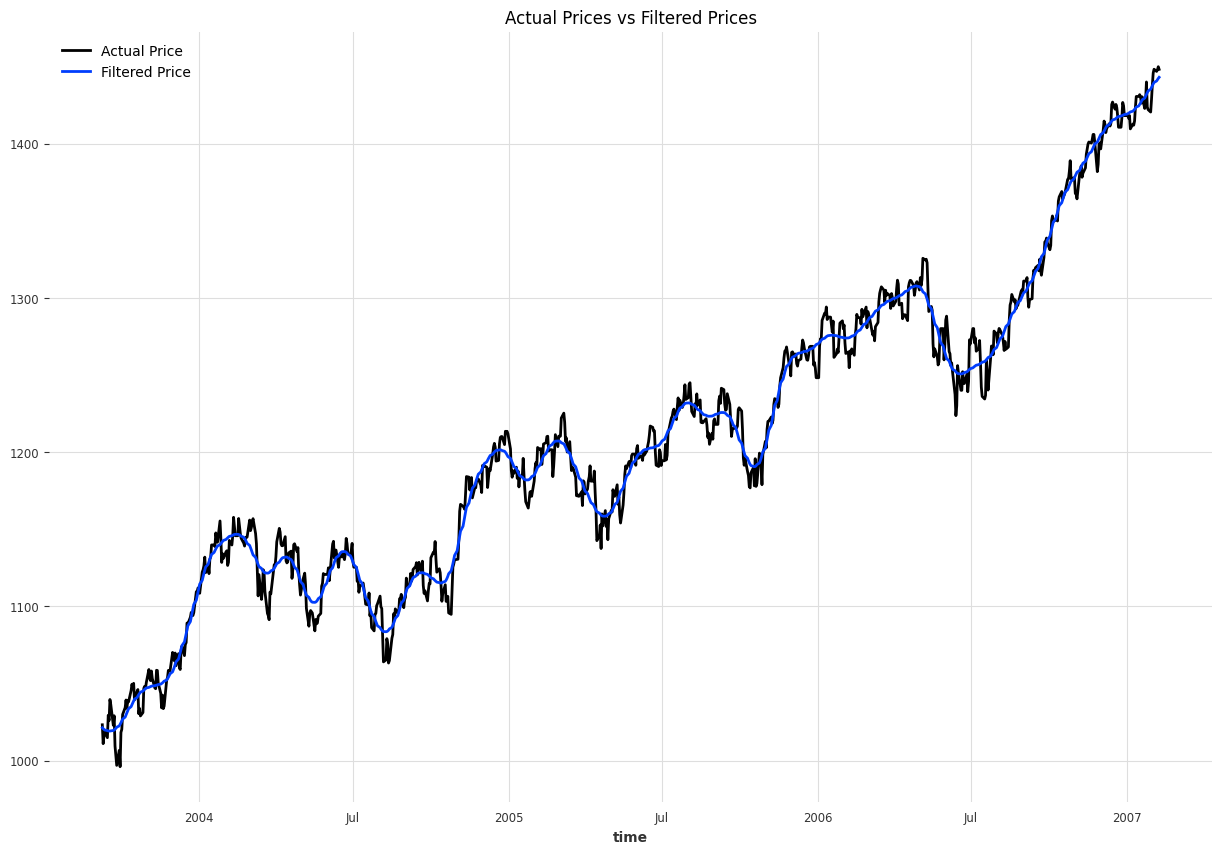

In [51]:
df, price, volume = load_data(debug=True)
length = len(price['ts'])
l,r = int(length*0.4),int(length*0.5)
plot_multiple_data({
    "Actual Price": price['ts'][l:r],
    "Filtered Price": apply_butterworth_filter(time_series=price['ts'][l:r], debug=True)
}, title = "Actual Prices vs Filtered Prices")

[*********************100%%**********************]  1 of 1 completed
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


✅Data loaded from yfinance. Rows: 8619.
✅Forward fill executed over the prices. Rows: 8927.
✅DataFrame converted into TimeSeries dtype.
	Price TS len: 8927
	Volume TS len: 8927
✅ Zero-phase Butterworth filter applied.
✅TimeSeries splitted into train/test TimeSeries.
	Price Train TS len / Price Test TS len: 8609 / 318
	Volume Train TS len / Volume Test TS len: 8609 / 318
✅TiDE model initialized with params: {'hidden_size': 128, 'input_chunk_length': 30, 'output_chunk_length': 100, 'n_epochs': 500, 'num_decoder_layers': 2, 'num_encoder_layers': 2, 'temporal_decoder_hidden': 64, 'random_state': 50, 'show_warnings': True}.



  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 74.0 K
4 | decoders         | Sequential       | 478 K 
5 | temporal_decoder | _ResidualBlock   | 1.2 K 
6 | lookback_skip    | Linear           | 3.1 K 
------------------------------------------------------
557 K     Trainable params
0         Non-trainable params
557 K     Total params
2.228     Total estimated model params size (MB)
/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 499: 100%|██████████| 265/265 [00:03<00:00, 78.29it/s, train_loss=5.33e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 265/265 [00:03<00:00, 78.27it/s, train_loss=5.33e+3]
✅Model fit completed.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.71it/s]
✅Predictions extracted.
✅MSE calculated: 303438.25


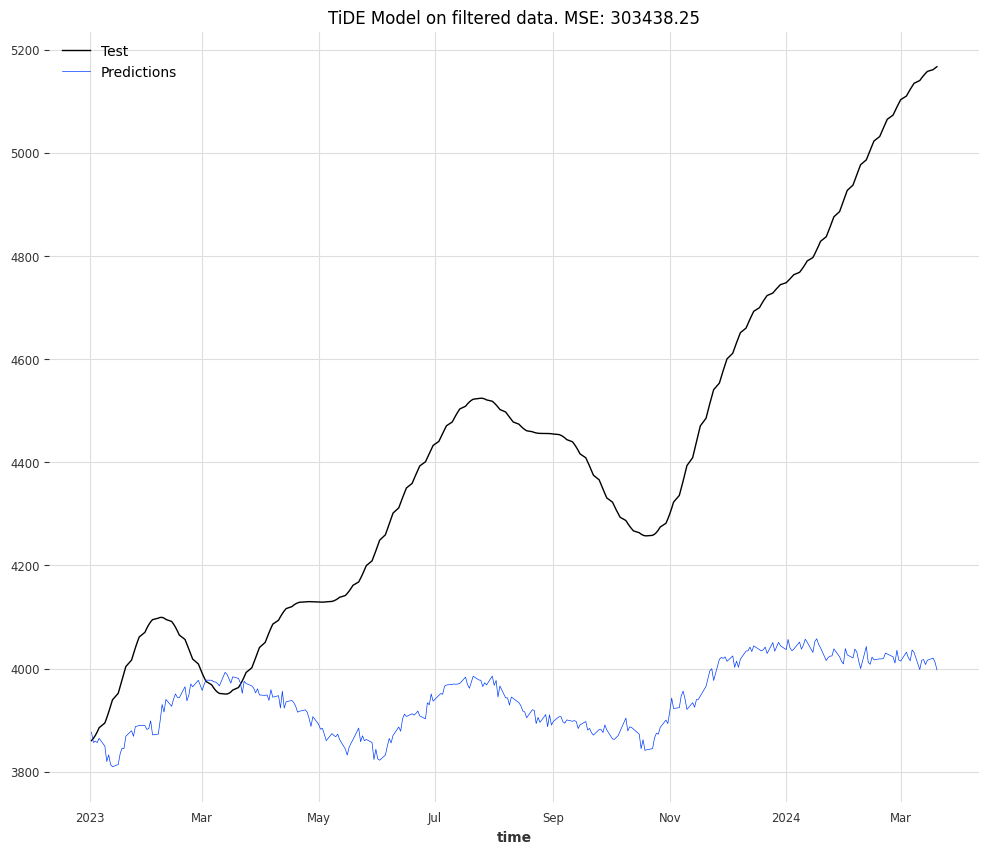

In [52]:
df, price, volume = load_data(apply_filter=True, debug=True)
model = train_tide(price['train_ts'],debug=True)
predictions_ts = get_predictions(model=model, length=len(price['test_ts']),debug=True)
mse = get_mse(price['test_ts'], predictions_ts, debug=True)
plot_predictions(price['test_ts'], predictions_ts, title = f"TiDE Model on filtered data. MSE: {mse}")

[*********************100%%**********************]  1 of 1 completed
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 89.3 K
4 | decoders         | Sequential       | 1.4 M 
5 | temporal_decoder | _ResidualBlock   | 1.2 K 
6 | lookback_skip    | Linear           | 28.9 K
------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.993     Total estimated model params size (MB)
/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'trai

✅Data loaded from yfinance. Rows: 3576.
✅Forward fill executed over the prices. Rows: 3708.
✅DataFrame converted into TimeSeries dtype.
	Price TS len: 3708
	Volume TS len: 3708
✅ Zero-phase Butterworth filter applied.
✅TimeSeries splitted into train/test TimeSeries.
	Price Train TS len / Price Test TS len: 3390 / 318
	Volume Train TS len / Volume Test TS len: 3390 / 318
✅TiDE model initialized with params: {'hidden_size': 128, 'input_chunk_length': 90, 'output_chunk_length': 318, 'n_epochs': 500, 'num_decoder_layers': 2, 'num_encoder_layers': 2, 'temporal_decoder_hidden': 64, 'random_state': 50, 'show_warnings': True}.
Epoch 499: 100%|██████████| 94/94 [00:01<00:00, 73.08it/s, train_loss=3.27e+4]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 94/94 [00:01<00:00, 73.04it/s, train_loss=3.27e+4]
✅Model fit completed.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.90it/s]
✅Predictions extracted.
✅MSE calculated: 269913.28125


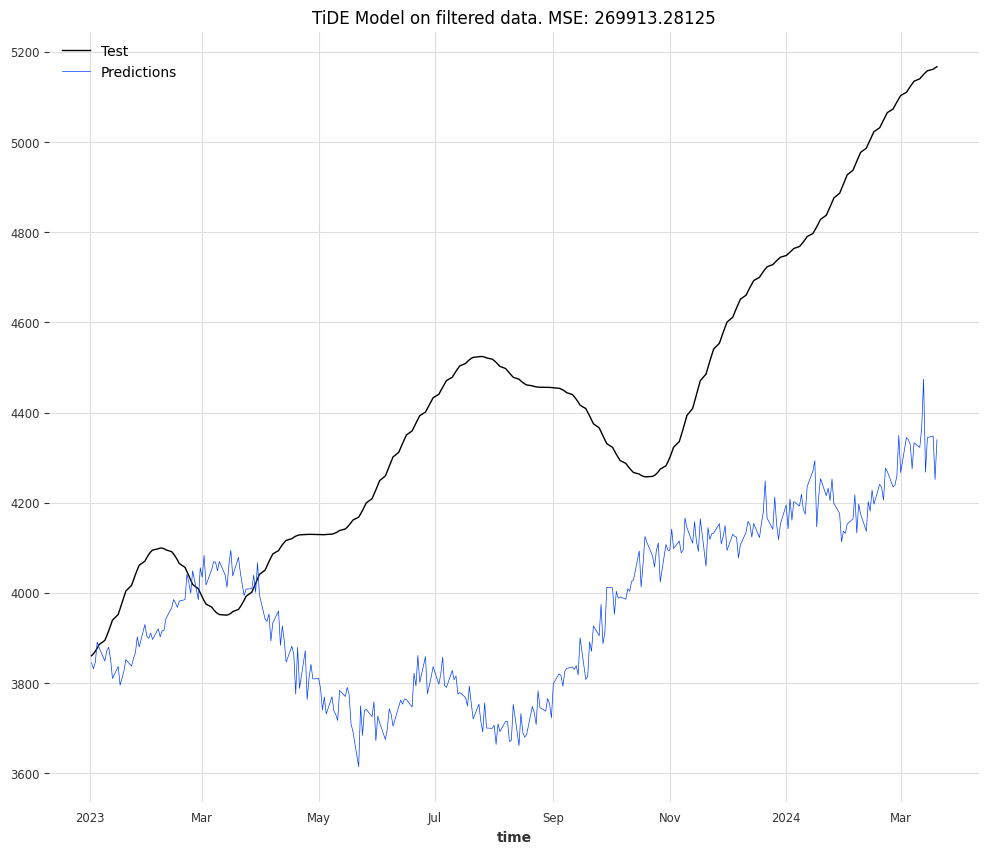

In [56]:
df, price, volume = load_data(start_date_str='2010-01-04', apply_filter=True, debug=True)
params = {
            'hidden_size': 128, 
            'input_chunk_length': 90, 
            'output_chunk_length': 318, 
            'n_epochs': 500, 
            'num_decoder_layers': 2, 
            'num_encoder_layers': 2, 
            'temporal_decoder_hidden': 64, 
            'random_state':50,
            'show_warnings':True
        }
model = train_tide(price['train_ts'],params=params,debug=True)
predictions_ts = get_predictions(model=model, length=len(price['test_ts']),debug=True)
mse = get_mse(price['test_ts'], predictions_ts, debug=True)
plot_predictions(price['test_ts'], predictions_ts, title = f"TiDE Model on filtered data. MSE: {mse}")

[*********************100%%**********************]  1 of 1 completed
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 128 K 
4 | decoders         | Sequential       | 528 K 
5 | temporal_decoder | _ResidualBlock   | 1.2 K 
6 | lookback_skip    | Linear           | 5.1 K 
------------------------------------------------------
663 K     Trainable params
0         Non-trainable params
663 K     Total params
2.653     Total estimated model params size (MB)
/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'trai

✅Data loaded from yfinance. Rows: 3576.
✅Forward fill executed over the prices. Rows: 3708.
✅DataFrame converted into TimeSeries dtype.
	Price TS len: 3708
	Volume TS len: 3708
✅ Zero-phase Butterworth filter applied.
✅TimeSeries splitted into train/test TimeSeries.
	Price Train TS len / Price Test TS len: 3390 / 318
	Volume Train TS len / Volume Test TS len: 3390 / 318
✅TiDE model initialized with params: {'hidden_size': 128, 'input_chunk_length': 50, 'output_chunk_length': 100, 'n_epochs': 500, 'num_decoder_layers': 3, 'num_encoder_layers': 3, 'temporal_decoder_hidden': 64, 'random_state': 50, 'show_warnings': True}.
Epoch 499: 100%|██████████| 102/102 [00:01<00:00, 56.59it/s, train_loss=3.35e+4]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 102/102 [00:01<00:00, 56.56it/s, train_loss=3.35e+4]
✅Model fit completed.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.07it/s]
✅Predictions extracted.
✅MSE calculated: 212353.859375


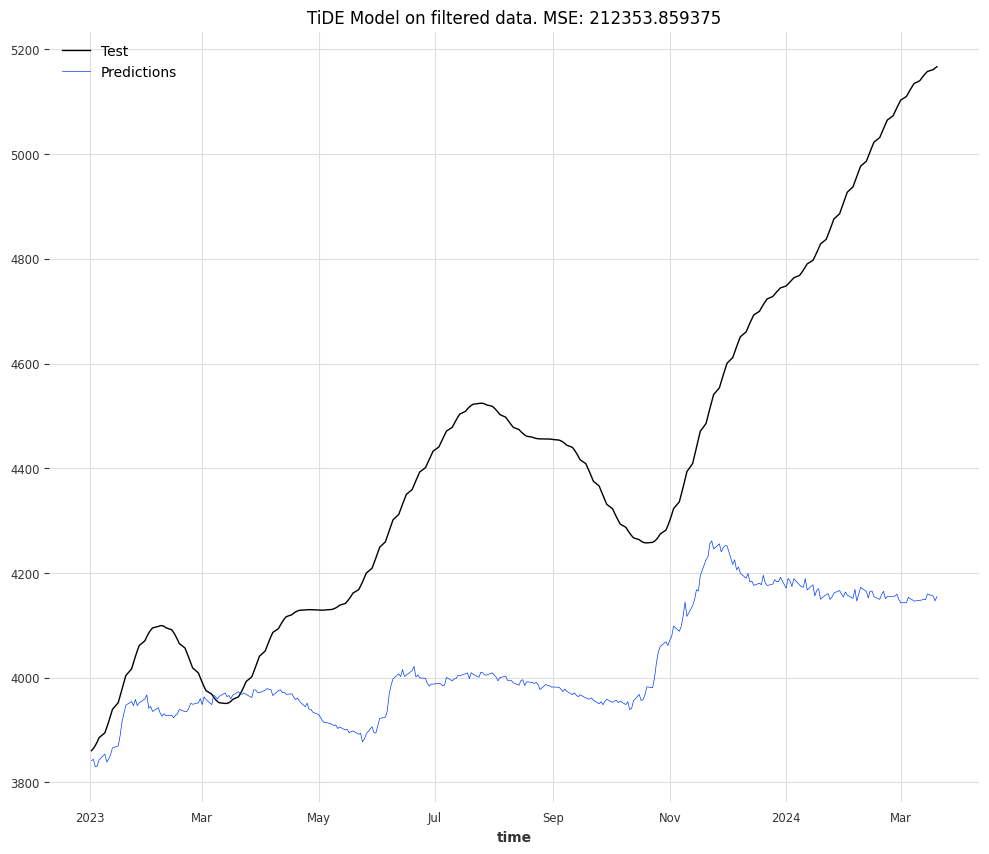

In [57]:
df, price, volume = load_data(start_date_str='2010-01-04', apply_filter=True, debug=True)
params = {
            'hidden_size': 128, 
            'input_chunk_length': 50, 
            'output_chunk_length': 100, 
            'n_epochs': 500, 
            'num_decoder_layers': 3, 
            'num_encoder_layers': 3, 
            'temporal_decoder_hidden': 64, 
            'random_state':50,
            'show_warnings':True
        }
model = train_tide(price['train_ts'],params=params,debug=True)
predictions_ts = get_predictions(model=model, length=len(price['test_ts']),debug=True)
mse = get_mse(price['test_ts'], predictions_ts, debug=True)
plot_predictions(price['test_ts'], predictions_ts, title = f"TiDE Model on filtered data. MSE: {mse}")

[*********************100%%**********************]  1 of 1 completed
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 128 K 
4 | decoders         | Sequential       | 528 K 
5 | temporal_decoder | _ResidualBlock   | 1.2 K 
6 | lookback_skip    | Linear           | 5.1 K 
------------------------------------------------------
663 K     Trainable params
0         Non-trainable params
663 K     Total params
2.653     Total estimated model params size (MB)
/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'trai

✅Data loaded from yfinance. Rows: 8619.
✅Forward fill executed over the prices. Rows: 8927.
✅DataFrame converted into TimeSeries dtype.
	Price TS len: 8927
	Volume TS len: 8927
✅ Zero-phase Butterworth filter applied.
✅TimeSeries splitted into train/test TimeSeries.
	Price Train TS len / Price Test TS len: 8609 / 318
	Volume Train TS len / Volume Test TS len: 8609 / 318
✅TiDE model initialized with params: {'hidden_size': 128, 'input_chunk_length': 50, 'output_chunk_length': 100, 'n_epochs': 500, 'num_decoder_layers': 3, 'num_encoder_layers': 3, 'temporal_decoder_hidden': 64, 'random_state': 50, 'show_warnings': True}.
Epoch 499: 100%|██████████| 265/265 [00:04<00:00, 64.13it/s, train_loss=3.01e+4]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 265/265 [00:04<00:00, 64.12it/s, train_loss=3.01e+4]
✅Model fit completed.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.52it/s]
✅Predictions extracted.
✅MSE calculated: 193316.8125


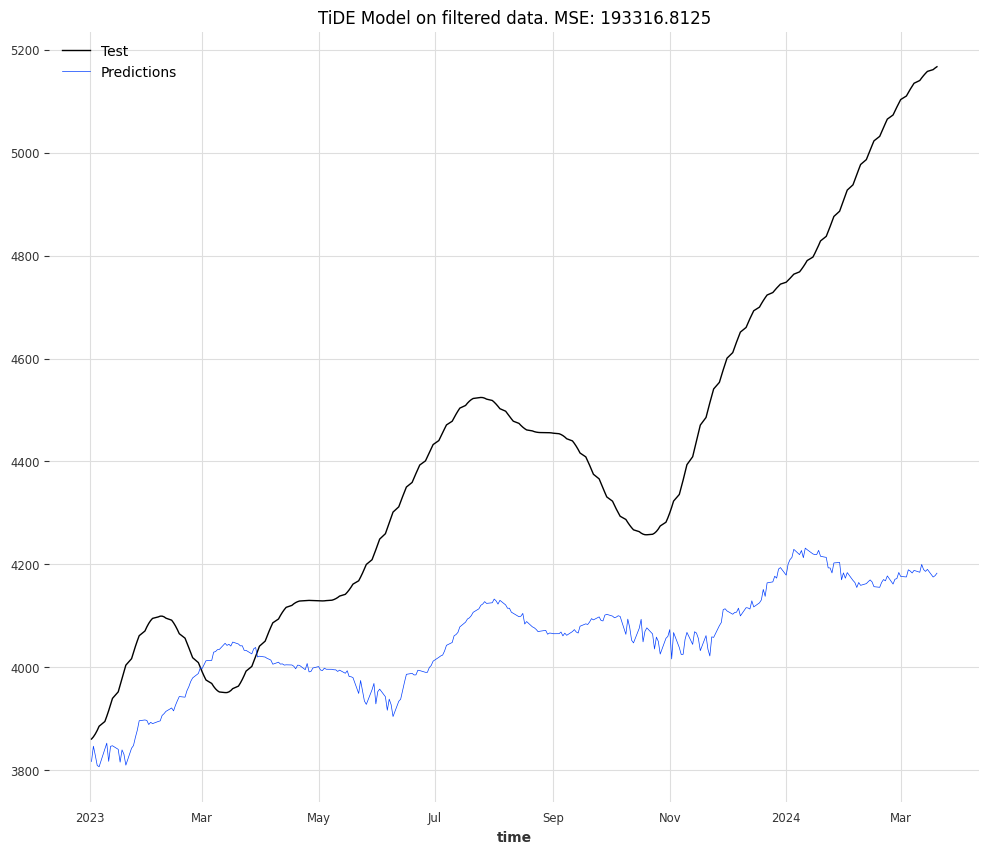

In [58]:
df, price, volume = load_data(apply_filter=True, debug=True)
params = {
            'hidden_size': 128, 
            'input_chunk_length': 50, 
            'output_chunk_length': 100, 
            'n_epochs': 500, 
            'num_decoder_layers': 3, 
            'num_encoder_layers': 3, 
            'temporal_decoder_hidden': 64, 
            'random_state':50,
            'show_warnings':True
        }
model = train_tide(price['train_ts'],params=params,debug=True)
predictions_ts = get_predictions(model=model, length=len(price['test_ts']),debug=True)
mse = get_mse(price['test_ts'], predictions_ts, debug=True)
plot_predictions(price['test_ts'], predictions_ts, title = f"TiDE Model on filtered data. MSE: {mse}")

[*********************100%%**********************]  1 of 1 completed
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 212 K 
4 | decoders         | Sequential       | 695 K 
5 | temporal_decoder | _ResidualBlock   | 1.2 K 
6 | lookback_skip    | Linear           | 10.1 K
------------------------------------------------------
919 K     Trainable params
0         Non-trainable params
919 K     Total params
3.678     Total estimated model params size (MB)
/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'trai

✅Data loaded from yfinance. Rows: 8619.
✅Forward fill executed over the prices. Rows: 8927.
✅DataFrame converted into TimeSeries dtype.
	Price TS len: 8927
	Volume TS len: 8927
✅ Zero-phase Butterworth filter applied.
✅TimeSeries splitted into train/test TimeSeries.
	Price Train TS len / Price Test TS len: 8609 / 318
	Volume Train TS len / Volume Test TS len: 8609 / 318
✅TiDE model initialized with params: {'hidden_size': 160, 'input_chunk_length': 100, 'output_chunk_length': 100, 'n_epochs': 500, 'num_decoder_layers': 3, 'num_encoder_layers': 3, 'temporal_decoder_hidden': 64, 'random_state': 50, 'show_warnings': True}.
Epoch 499: 100%|██████████| 263/263 [00:03<00:00, 67.94it/s, train_loss=1.05e+4]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 263/263 [00:03<00:00, 67.92it/s, train_loss=1.05e+4]
✅Model fit completed.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]
✅Predictions extracted.
✅MSE calculated: 347530.6875


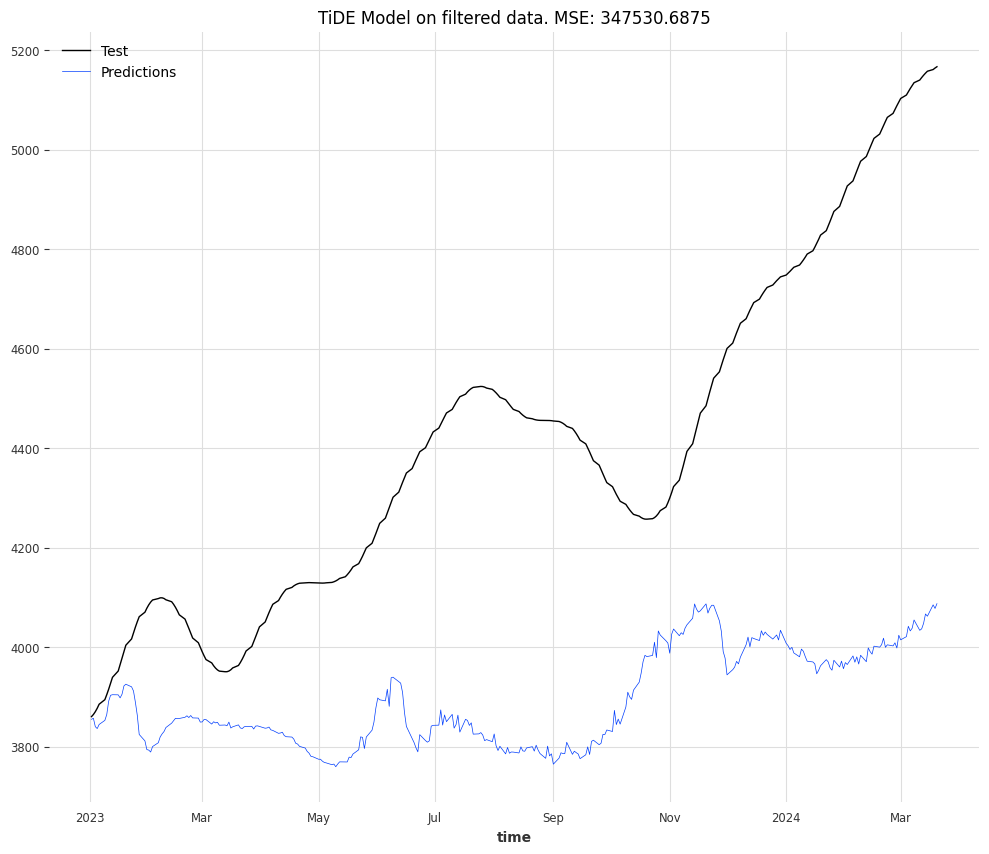

In [59]:
df, price, volume = load_data(apply_filter=True, debug=True)
params = {
            'hidden_size': 160, 
            'input_chunk_length': 100, 
            'output_chunk_length': 100, 
            'n_epochs': 500, 
            'num_decoder_layers': 3, 
            'num_encoder_layers': 3, 
            'temporal_decoder_hidden': 64, 
            'random_state':50,
            'show_warnings':True
        }
model = train_tide(price['train_ts'],params=params,debug=True)
predictions_ts = get_predictions(model=model, length=len(price['test_ts']),debug=True)
mse = get_mse(price['test_ts'], predictions_ts, debug=True)
plot_predictions(price['test_ts'], predictions_ts, title = f"TiDE Model on filtered data. MSE: {mse}")